In [75]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
import os
import re
import io
import ast
import sys
import json
import boto3
import pymongo 
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from matplotlib import cm
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image
from urllib import request
from collections import Counter

sys.path.append("../")
import cabutils

In [77]:
sns.set_style("darkgrid")
sns.set_context("notebook")

In [78]:
from matplotlib import rcParams
rcParams["font.size"] = 18
rcParams["figure.titlesize"] = 26

In [173]:
projName = "mlve"
experiment = "nsd"
experimentName = f"{experiment}-surface-normals"
S3_BUCKET_NAME = "mlve-v1"

attention_check = "attentionCheck"
batch_idx = "batchIdx"

To download data (@Yoni only), run: 
ssh -i ~/.aws/cocosci_ec2.pem -NL 8000:localhost:27017  ubuntu@ec2-3-90-78-57.compute-1.amazonaws.com

# Downloading data from ec2 server (mostly just instructions for thomas)

In `settings.conf` change the `MONGODB_PORT` to 8000, and the `MONGODB_HOST` to `localhost`. Then run the ssh port into the ec2 server: 

```
ssh -i path/to/pem/key/maybe-named-something-like/Cocosci_WebExperiments.pem -fNL 8000:localhost:27017 ubuntu@ec2-54-91-252-25.compute-1.amazonaws.com
```

Change the path to the pem key, but otherwise this should all stay the same.

In [174]:
conn = cabutils.get_db_connection()
db = conn[projName + "_outputs"]
col = db[experimentName]

Checking database connection...
Connection established!


In [175]:
names = list(db.list_collection_names())
names.sort()

In [176]:
names

['gestalt_object-loc',
 'gestalt_shapegen-depth-estimation-pilot',
 'gestalt_shapegen-depth-estimation-split-half',
 'gestalt_shapegen-segmentation-split-half',
 'gestalt_shapegen-surface-normals',
 'gestalt_shapegen-surface-normals-split-half',
 'gestalt_shapegen_object-loc',
 'gestalt_shapegen_video-object-loc',
 'gestalt_video-object-loc',
 'hypersim_surface-normals',
 'hypersim_surface-normals-splithalf',
 'hypersim_v2-depth-estimation-pilot',
 'hypersim_v3-depth-estimation-split-half',
 'hypersim_v3-segmentation-split-half',
 'hypersim_v3-surface-normals',
 'nsd-depth-estimation-pilot',
 'nsd-object-loc-split-half',
 'nsd-segmentation',
 'nsd-surface-normals',
 'nsd_surface-normals',
 'tdw-depth-estimation-pilot',
 'tdw-depth-estimation-split-half',
 'tdw-segmentation',
 'tdw-segmentation-split-half',
 'tdw-surface-normals-split-half',
 'tdw_surface-normals']

In [177]:
def results_to_df(iterName=None):
    results = []
    cursor = col.find({})
    for document in tqdm(cursor):
        results.append(document)
    
    df = pd.DataFrame(results)
    return df

df = results_to_df()

21948it [01:01, 358.69it/s]


In [179]:
df['trial_type'].unique()

array(['jspsych-surface-normals', 'survey-text'], dtype=object)

In [167]:
batchkey = lambda x: [key for key in x if "batch" in key][0]

batchkey(df.columns)

'batchIdx'

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21871 entries, 0 to 21870
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _id                             21871 non-null  object 
 1   imageMetadata                   20412 non-null  object 
 2   imageURL                        21671 non-null  object 
 3   trialType                       21671 non-null  object 
 4   isDuplicate                     21671 non-null  object 
 5   arrowPosition                   21671 non-null  object 
 6   arrowPixelPosition              21671 non-null  object 
 7   randomizeArrowInitialDirection  21671 non-null  object 
 8   attentionCheck                  21671 non-null  object 
 9   batchIdx                        21671 non-null  float64
 10  confidence                      0 non-null      float64
 11  indicatorFinalDirection         21671 non-null  object 
 12  indicatorDirectionTrajectory    

In [89]:
iterNames = ["v2-all"]
df = df.query(f"iterationName in {iterNames}")

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7906 entries, 13965 to 21870
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _id                             7906 non-null   object 
 1   imageMetadata                   7185 non-null   object 
 2   imageURL                        7806 non-null   object 
 3   trialType                       7806 non-null   object 
 4   isDuplicate                     7806 non-null   object 
 5   arrowPosition                   7806 non-null   object 
 6   arrowPixelPosition              7806 non-null   object 
 7   randomizeArrowInitialDirection  7806 non-null   object 
 8   attentionCheck                  7806 non-null   object 
 9   batchIdx                        7806 non-null   float64
 10  confidence                      0 non-null      float64
 11  indicatorFinalDirection         7806 non-null   object 
 12  indicatorDirectionTrajectory 

In [91]:
for i, x in df[df["trial_type"] == "survey-text"].iterrows():
    if x["response"]["participantComments"] or x["response"]["TechnicalDifficultiesFreeResp"]:
        print(x["response"])

{'TechnicalDifficultiesFreeResp': 'Worked ok for me', 'participantComments': 'nope '}
{'TechnicalDifficultiesFreeResp': 'No difficulties', 'participantComments': 'I had some fun but it was so frustrated to not know if i was pointing in the right direction haha'}
{'TechnicalDifficultiesFreeResp': 'No technical difficulties. ', 'participantComments': 'Not sure if I did this right. Had trouble figuring out what the test wanted me to aim the indicator away from.'}
{'TechnicalDifficultiesFreeResp': 'I think everything worked fine.', 'participantComments': 'Thank you for allowing me to participate!'}
{'TechnicalDifficultiesFreeResp': 'none', 'participantComments': 'n/a'}
{'TechnicalDifficultiesFreeResp': "I didn't notice any.", 'participantComments': 'That was a blast! Thank you so much!'}
{'TechnicalDifficultiesFreeResp': '', 'participantComments': 'Aiming the pointer requires a lot of precision with the mouse and can be finicky at times. I did have fun though!'}
{'TechnicalDifficultiesFree

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7906 entries, 13965 to 21870
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _id                             7906 non-null   object 
 1   imageMetadata                   7185 non-null   object 
 2   imageURL                        7806 non-null   object 
 3   trialType                       7806 non-null   object 
 4   isDuplicate                     7806 non-null   object 
 5   arrowPosition                   7806 non-null   object 
 6   arrowPixelPosition              7806 non-null   object 
 7   randomizeArrowInitialDirection  7806 non-null   object 
 8   attentionCheck                  7806 non-null   object 
 9   batchIdx                        7806 non-null   float64
 10  confidence                      0 non-null      float64
 11  indicatorFinalDirection         7806 non-null   object 
 12  indicatorDirectionTrajectory 

In [93]:
df.head()

,_id,imageMetadata,imageURL,trialType,isDuplicate,arrowPosition,arrowPixelPosition,randomizeArrowInitialDirection,attentionCheck,batchIdx,...,inputid,projName,expName,sessionID,studyID,userID,trueArrowDirection,rt,response,mask_val
13965,63719a56538bb3f4bfbb4aa6,"{'shared_idx': 'shared0896', 'nsd_idx': 65253,...",https://mlve-v1.s3.us-east-2.amazonaws.com/nsd...,unsupervised,True,"[1.6900000000000004, 2.8900000000000006, 0]","[297, 357]",True,False,0.0,...,None,mlve,nsd-surface-normals,None,None,yoni_test,NaN,NaN,NaN,215.0
13966,63719a5b538bb3f4bfbb4aa7,"{'shared_idx': 'shared0614', 'nsd_idx': 45213,...",https://mlve-v1.s3.us-east-2.amazonaws.com/nsd...,unsupervised,True,"[0.4500000000000002, -2.21, 0]","[235, 102]",True,False,0.0,...,None,mlve,nsd-surface-normals,None,None,yoni_test,NaN,NaN,NaN,139.0
13967,63719a69538bb3f4bfbb4aa8,"{'shared_idx': 'shared0876', 'nsd_idx': 63931,...",https://mlve-v1.s3.us-east-2.amazonaws.com/nsd...,unsupervised,False,"[0.8300000000000001, -0.48999999999999977, 0]","[254, 188]",True,False,0.0,...,None,mlve,nsd-surface-normals,None,None,yoni_test,NaN,NaN,NaN,215.0
13968,63719a6f538bb3f4bfbb4aa9,"{'shared_idx': 'shared0689', 'nsd_idx': 50114,...",https://mlve-v1.s3.us-east-2.amazonaws.com/nsd...,unsupervised,False,"[2.6900000000000004, 0.7300000000000004, 0]","[347, 249]",True,False,0.0,...,None,mlve,nsd-surface-normals,None,None,yoni_test,NaN,NaN,NaN,204.0
13969,63719a74538bb3f4bfbb4aaa,"{'shared_idx': 'shared0811', 'nsd_idx': 59023,...",https://mlve-v1.s3.us-east-2.amazonaws.com/nsd...,unsupervised,False,"[-2.3499999999999996, 2.1900000000000004, 0]","[95, 322]",True,False,0.0,...,None,mlve,nsd-surface-normals,None,None,yoni_test,NaN,NaN,NaN,200.0


In [94]:
df.drop("trial_type", axis=1, inplace=True)
df.drop("rt", axis=1, inplace=True)
df.drop("response", axis=1, inplace=True)
df.drop("inputid", axis=1, inplace=True)

In [95]:
df.drop(df[df["indicatorFinalDirection"].isna() == True].index, inplace=True)

In [96]:
df.drop(df[df["trueArrowDirection"].apply(lambda x: x == [None, None, None]) == True].index, inplace=True)

In [97]:
def download_from_s3(url, resource_type="image"):
    s3 = boto3.resource('s3', region_name="us-east-2")
    bucket = s3.Bucket(S3_BUCKET_NAME)
    item = bucket.Object(url)
    if resource_type == "image":
        file_stream = io.BytesIO()
        item.download_fileobj(file_stream)
        img = Image.open(file_stream)
        return img
    
    else:
        return item

In [98]:
def download_from_url(url):
    obj = request.urlretrieve(url)
    image = Image.open(obj[0])
    return image

In [99]:
def draw_circles(ax, locs, size=10, edgecolor="red", facecolor="none", lw=2):
    """
    draws circle patches on an image at specified locations
    """
    for point in locs:
        circ = patches.Circle((point[1], point[0]), size, ec=edgecolor, fc=facecolor, lw=lw)
        ax.add_patch(circ)
    return ax


In [100]:
def cos_similarity(a, b):
    a = np.array(a)
    b = np.array(b)
    return a.dot(b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [106]:
def geodesic_dist(a, b):
    a = np.array(a)
    b = np.array(b)
    if not a.shape or not b.shape:
        return float("nan")

    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    
    dist = np.arccos(a.dot(b))
    return dist

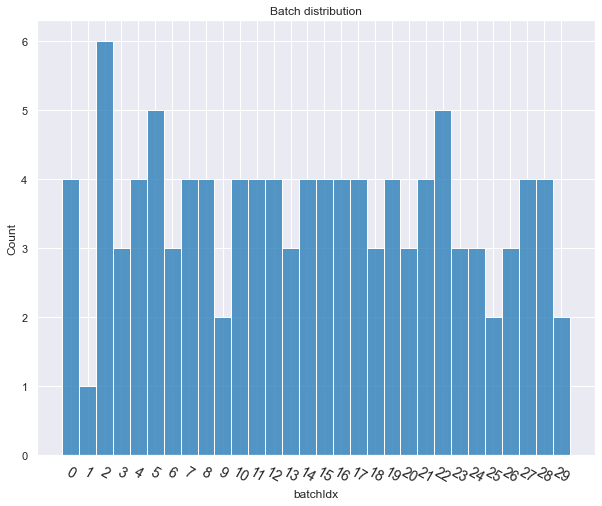

In [156]:
fig = plt.figure(figsize=(10,8))
batch_counts = df.groupby("userID")["batchIdx"].mean() # sort of hacky way to get per-
sns.histplot(x=batch_counts, stat="count", binwidth=1, bins=10, discrete=True)
plt.xticks(range(30), range(30), rotation=330, fontsize=14)
plt.title("Batch distribution")
plt.show()

### Check user consistency

In [115]:
potential_fails = []
for user, rows in df.groupby("userID"):
    attention_checks = rows[rows[attention_check]]
    ifd = attention_checks["indicatorFinalDirection"].values
    tad = attention_checks["trueArrowDirection"].values
    
    dists = [geodesic_dist(a, b) for a, b in zip(ifd, tad)]
    score = np.mean(dists)
    if score > 0.5:
        print(user, score)
        potential_fails.append(user)
        
df = df[df["attentionCheck"] == False]
print(potential_fails)

56a552c681a8ca000b3e4bb6 0.8308837394567693
5ba345bcf07414000106135e 0.5967507229809935
5bae7511408bf900018fbaa5 0.971663768931036
5cf5134c8f8ff80019e76721 1.3695283821077648
5f8b25654f85cb21a4fa0fb3 1.5563702187339514
5f9fdfd04296cb0102563f84 2.2159674400071263
6107a4b7744b9b0ca7328cee 0.7002874270130528
6119d9f5a882080ef1c9e9e6 1.248512342136457
6138c06bd7d7f2b7720e7a27 1.5040109122171241
6163fe9d6927a2f26b731798 0.6290509784833084
6296267b2ae249a205d319d3 0.9074410382670844
['56a552c681a8ca000b3e4bb6', '5ba345bcf07414000106135e', '5bae7511408bf900018fbaa5', '5cf5134c8f8ff80019e76721', '5f8b25654f85cb21a4fa0fb3', '5f9fdfd04296cb0102563f84', '6107a4b7744b9b0ca7328cee', '6119d9f5a882080ef1c9e9e6', '6138c06bd7d7f2b7720e7a27', '6163fe9d6927a2f26b731798', '6296267b2ae249a205d319d3']


/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:

Mean of empty slice.

/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars



In [116]:
def l2_distance(a, b):
    return np.mean((np.array(a) - np.array(b)) ** 2)

In [117]:
df["geodesic_distance"] = df.apply(lambda x: geodesic_dist(x["indicatorFinalDirection"], x["trueArrowDirection"]), axis=1)
df["cosine_similarity"] = df.apply(lambda x: cos_similarity(x["indicatorFinalDirection"], x["trueArrowDirection"]), axis=1)
df["l2_distance"] = df.apply(lambda x: l2_distance(x["indicatorFinalDirection"], x["trueArrowDirection"]), axis=1)

/var/folders/vz/qv2p5zmj48g74_wv3kzkjlmc0000gn/T/ipykernel_43183/3134414652.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/vz/qv2p5zmj48g74_wv3kzkjlmc0000gn/T/ipykernel_43183/3134414652.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/vz/qv2p5zmj48g74_wv3kzkjlmc0000gn/T/ipykernel_43183/3134414652.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [118]:
for user in potential_fails:
    print(df[df["userID"] == user]["geodesic_distance"].mean(), user)

nan 56a552c681a8ca000b3e4bb6
nan 5ba345bcf07414000106135e
nan 5bae7511408bf900018fbaa5
nan 5cf5134c8f8ff80019e76721
nan 5f8b25654f85cb21a4fa0fb3
nan 5f9fdfd04296cb0102563f84
nan 6107a4b7744b9b0ca7328cee
nan 6119d9f5a882080ef1c9e9e6
nan 6138c06bd7d7f2b7720e7a27
nan 6163fe9d6927a2f26b731798
nan 6296267b2ae249a205d319d3


/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6607: RuntimeWarning:

All-NaN slice encountered

/Users/yonifriedman/.miniconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6608: RuntimeWarning:

All-NaN slice encountered



ValueError: autodetected range of [nan, nan] is not finite

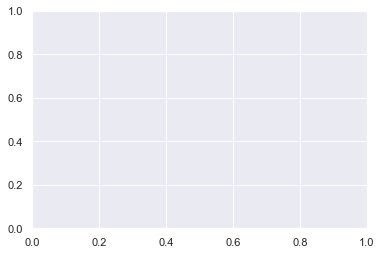

In [119]:
geo_errors = []
n_users = 0
for user, rows in df.groupby("imageURL"):
    geo_errors.append(rows["geodesic_distance"].mean())
    n_users += 1
    
plt.hist(geo_errors, bins=15)
plt.show()
    

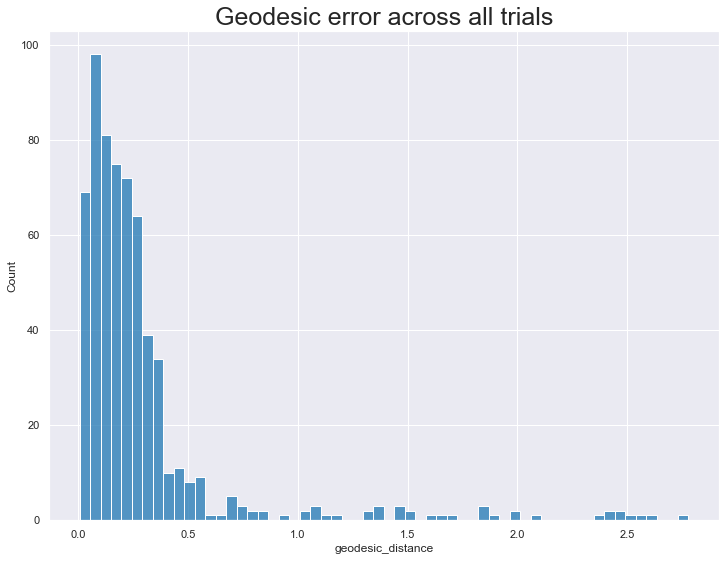

In [112]:

fig, axs = plt.subplots(1, 1, figsize=(12,9))
sns.histplot(df["geodesic_distance"], ax=axs)
# sns.histplot(df["cosine_similarity"], ax=axs[1])

axs.set_title(f"Geodesic error across all trials", fontsize=25)
# axs[1].set_title(f"Cosine similarity across all trials", fontsize=25)
# plt.suptitle(f"{experimentName}")

plt.show()

# Generate cleaned version

In [120]:
df.head()

,_id,imageMetadata,imageURL,trialType,isDuplicate,arrowPosition,arrowPixelPosition,randomizeArrowInitialDirection,attentionCheck,batchIdx,...,projName,expName,sessionID,studyID,userID,trueArrowDirection,mask_val,geodesic_distance,cosine_similarity,l2_distance
13965,63719a56538bb3f4bfbb4aa6,"{'shared_idx': 'shared0896', 'nsd_idx': 65253,...",https://mlve-v1.s3.us-east-2.amazonaws.com/nsd...,unsupervised,True,"[1.6900000000000004, 2.8900000000000006, 0]","[297, 357]",True,False,0.0,...,mlve,nsd-surface-normals,None,None,yoni_test,NaN,215.0,NaN,"[nan, nan, nan]",NaN
13966,63719a5b538bb3f4bfbb4aa7,"{'shared_idx': 'shared0614', 'nsd_idx': 45213,...",https://mlve-v1.s3.us-east-2.amazonaws.com/nsd...,unsupervised,True,"[0.4500000000000002, -2.21, 0]","[235, 102]",True,False,0.0,...,mlve,nsd-surface-normals,None,None,yoni_test,NaN,139.0,NaN,"[nan, nan, nan]",NaN
13967,63719a69538bb3f4bfbb4aa8,"{'shared_idx': 'shared0876', 'nsd_idx': 63931,...",https://mlve-v1.s3.us-east-2.amazonaws.com/nsd...,unsupervised,False,"[0.8300000000000001, -0.48999999999999977, 0]","[254, 188]",True,False,0.0,...,mlve,nsd-surface-normals,None,None,yoni_test,NaN,215.0,NaN,"[nan, nan, nan]",NaN
13968,63719a6f538bb3f4bfbb4aa9,"{'shared_idx': 'shared0689', 'nsd_idx': 50114,...",https://mlve-v1.s3.us-east-2.amazonaws.com/nsd...,unsupervised,False,"[2.6900000000000004, 0.7300000000000004, 0]","[347, 249]",True,False,0.0,...,mlve,nsd-surface-normals,None,None,yoni_test,NaN,204.0,NaN,"[nan, nan, nan]",NaN
13969,63719a74538bb3f4bfbb4aaa,"{'shared_idx': 'shared0811', 'nsd_idx': 59023,...",https://mlve-v1.s3.us-east-2.amazonaws.com/nsd...,unsupervised,False,"[-2.3499999999999996, 2.1900000000000004, 0]","[95, 322]",True,False,0.0,...,mlve,nsd-surface-normals,None,None,yoni_test,NaN,200.0,NaN,"[nan, nan, nan]",NaN


In [121]:
participants = df.groupby("userID")
participants_failed = []
i = 0 
batch_idxs = []
for index, user_results in participants:
    i += 1
    batch_idxs.append(user_results.iloc[0][batch_idx])
    
    if len(user_results) < 100:
        print("USER ID: " + user_results["userID"].iloc[0] + " did not finish the experiment")
        participants_failed.append(user_results["userID"].iloc[0])
        continue
    
    if user_results["geodesic_distance"].mean() > 1.5:
        print("USER ID: " + user_results["userID"].iloc[0] + " did not do too well")
        continue
        
    attention_checks = user_results[user_results[attention_check]] == True
    attention_score = attention_checks["geodesic_distance"].mean()
    if attention_score > 1:
        print("USER ID: " + user_results["userID"].iloc[0] + "scored: " + attention_score)
        participants_failed.append(user_results["userID"].iloc[0])

print(participants_failed)

# failed_participants = df["userID"].apply(lambda x: x in participants_failed)
# df = df[~failed_participants]
# attention_checks = df["stimulus"].apply(lambda x: "ground_truth" in x)
# df = df[~attention_checks]

# my_data = df["userID"] == "yoni_test2"
# df = df[~my_data]

USER ID: 55a75835fdf99b26395fae40 did not finish the experiment
USER ID: 55b1add5fdf99b6731f04c5a did not finish the experiment
USER ID: 55fb068b77f33b0005cb1efc did not finish the experiment
USER ID: 56272eeeddff3c0011bcdb7e did not finish the experiment
USER ID: 5699cf0625d9e9000db0c789 did not finish the experiment
USER ID: 56a552c681a8ca000b3e4bb6 did not finish the experiment
USER ID: 56ab103610b779000bcb4cb5 did not finish the experiment
USER ID: 587305bbdb3e720001e231cf did not finish the experiment
USER ID: 5928a8295404290001dbe9bc did not finish the experiment
USER ID: 5a67725b63394a000155abbb did not finish the experiment
USER ID: 5ac6e74f9534ba0001c756d5 did not finish the experiment
USER ID: 5aea962d0ef2f20001858c9c did not finish the experiment
USER ID: 5b05e0d131cebe000177c38e did not finish the experiment
USER ID: 5b70ed4b99982e000145eb7b did not finish the experiment
USER ID: 5b774f493c1375000197ad11 did not finish the experiment
USER ID: 5ba345bcf07414000106135e did no

In [122]:
attention_indexes = df[df[attention_check] == True].index
df.drop(attention_indexes, axis=0, inplace=True)

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7185 entries, 13965 to 21869
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _id                             7185 non-null   object 
 1   imageMetadata                   7185 non-null   object 
 2   imageURL                        7185 non-null   object 
 3   trialType                       7185 non-null   object 
 4   isDuplicate                     7185 non-null   object 
 5   arrowPosition                   7185 non-null   object 
 6   arrowPixelPosition              7185 non-null   object 
 7   randomizeArrowInitialDirection  7185 non-null   object 
 8   attentionCheck                  7185 non-null   object 
 9   batchIdx                        7185 non-null   float64
 10  confidence                      0 non-null      float64
 11  indicatorFinalDirection         7185 non-null   object 
 12  indicatorDirectionTrajectory 

# split half reliability

In [124]:
batch_df = df[df["batchIdx"] == batchIdx]
batch_df = batch_df[batch_df["isDuplicate"] != True]
len(batch_df["userID"].unique())

4

Minimum people per trial: 2
(100, 2, 3) trials to choose from
Subs per split []
[] range(0, 0)


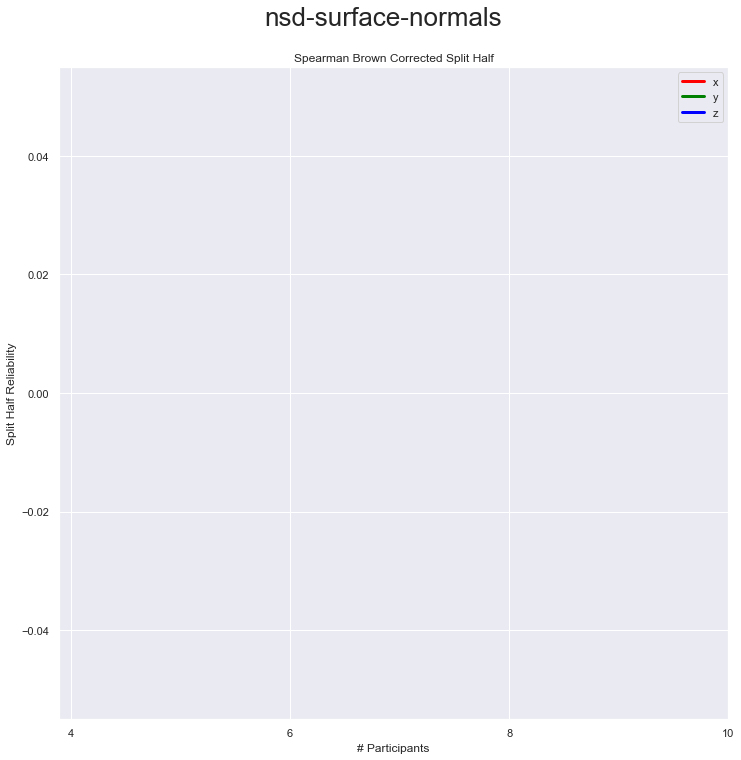

In [125]:
# Split data by user
# For each trial correlate half and half splits

# def calculate_splithalf(split_num, batchIdx=0):
"""
split_num: int: number of participants to sample for each half (ie; if split_num is 5, you choose 5 people for group A and 5 for group B)
"""


batchIdx = 0
def compute_split_half(batchIdx):
    batch_df = df.loc[df["batchIdx"] == batchIdx]
    batch_df = batch_df[batch_df["isDuplicate"] != True]

    # Build data table
    trials = [np.array(x[1].values[:]) for x in batch_df.groupby("imageURL")["indicatorFinalDirection"]]
    data = []
    min_subs_per_point = np.min([len(x) for x in trials])
    print("Minimum people per trial:", min_subs_per_point)
    
    for x in trials:
        data.append([])
        for y in range(min_subs_per_point):
            data[-1].append(x[y])
    data = np.array(data)
    print(f"{data.shape} trials to choose from")

    # Take 1000 random splits of participants
    splits = 1000
    split_halfs = np.ndarray((splits, 3))
    n_subs_half = min_subs_per_point // 2
    
    subs_per_split = np.arange(2,(min_subs_per_point // 2) + 1, 1)
    print("Subs per split", subs_per_split)
    split_halfs_by_n = np.ndarray((len(subs_per_split), splits, 3))
    split_halfs_by_n_sb = np.ndarray((len(subs_per_split), splits, 3))
    for i0, n_subs_half in enumerate(subs_per_split):
        for i in range(splits):
            inds = np.random.choice(range(min_subs_per_point), int(n_subs_half*2), replace=False)
            vec0 = np.mean(data[:,inds[:n_subs_half],:], axis=1)
            vec1 = np.mean(data[:, inds[n_subs_half:], :], axis=1)
            for dim in range(3):
                stat = np.corrcoef(vec1[:,dim], vec0[:,dim])[0][1]
                split_halfs_by_n[i0, i, dim] = stat
                split_halfs_by_n_sb[i0, i, dim] = (2*stat) / (1+stat)

    return split_halfs_by_n, split_halfs_by_n_sb

batch_id = 0
split_halfs_by_n, split_halfs_by_n_sb = compute_split_half(batch_id)
fig = plt.figure(figsize=(12,12))
cs = ["r", "g", "b"]
dim = ["x", "y", "z"]
n_split_halfs = len(np.mean(split_halfs_by_n, axis=1))
for i in range(3):
    plt.plot(np.mean(split_halfs_by_n, axis=1)[:, i], lw=1, c=cs[i], ls="--", label=dim[i])
    plt.plot(np.mean(split_halfs_by_n_sb, axis=1)[:, i], lw=3, c=cs[i], label=dim[i])

print( 2*np.arange(1, n_split_halfs + 1), range(n_split_halfs))

plt.xticks(range(4), 2*np.arange(2, 6))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.xlabel("# Participants")
plt.ylabel("Split Half Reliability")
plt.legend(by_label.values(), by_label.keys())
plt.title("Spearman Brown Corrected Split Half")
plt.suptitle(experimentName, y=0.95)
plt.show()



In [126]:
def plot_splithalf():
    fig = plt.figure(figsize=(12,8))
    batches_r = []
    batches_spb = [] 
    max_participants = 8
    split_nums = [x // 2 for x in range(2, max_participants + 1, 2)]
    batches = 8
    for b in range(batches):
        rs = []
        spbs = []
        for split_num in split_nums:    
            r, spb = calculate_splithalf(split_num, batchIdx=b)
            spbs.append(spb)
            rs.append(r)
        batches_r.append(rs)
        batches_spb.append(spbs)

    plt.yticks(fontsize=22)
    plt.xticks(split_nums, [n * 2 for n in split_nums], fontsize=22)
    batch_r = np.mean(batches_r, axis=0)
    batch_spb = np.mean(batches_spb, axis=0)
    print(batch_r.shape)

    plt.plot(split_nums, batch_r, lw=6, color="red", label="Pearson R")
    plt.plot(split_nums, batch_spb, lw=6, color="blue", label="Spearman-Brown Corrected")
    for b in range(batches):
        rs = batches_r[b]
        spbs = batches_spb[b]
        plt.plot(split_nums, rs, lw=3, alpha=0.25, color="red")
        plt.plot(split_nums, spbs, lw=3, alpha=0.25, color="blue")
        plt.xlabel("N Participants", fontsize=22)
        plt.ylabel("Reliability", fontsize=22)


    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title("Split Half Reliability", fontsize=22)
    plt.suptitle(f"{experimentName}")
    plt.show()

# To-Do:

2. Check consistency
3. Rank participants by score
4. Check which trials had the lowest score

## Visualization Ideas

4. Each image w/ probe locations --> put em in a zip
3. Heatmap on a sphere?
1. Download image -- overlay subject estimates with arrow
6. Correlate (X, Y) with estimate + error
5. NSD --> Check participant distribution (histogram, heatmap)
7. Surface normal UNet / model?

### long shot vis
1. Compare distribution of histograms across datasets

## Plot the distribution of surface normals

In [127]:
indicator_directions = np.array([x for x in df["indicatorFinalDirection"]])
true_directions = np.array([x for x in df["trueArrowDirection"]])

In [128]:
### from tqdm.notebook import tqdm

def near( p, pntList, d0 ):
    cnt=0
    for pj in pntList:
        dist=geodesic_dist(p, pj)
        if dist < d0:
            cnt += 1 - dist/d0
    return cnt


"""
https://stackoverflow.com/questions/22128909/plotting-the-temperature-distribution-on-a-sphere-with-python
"""

def calculate_heatmap(pointList, threshold=0.5):

    u = np.linspace( 0, 2 * np.pi, 20)
    v = np.linspace( 0, np.pi, 20)

    # create the sphere surface
    XX = np.outer( np.cos( u ), np.sin( v ) )
    YY = np.outer( np.sin( u ), np.sin( v ) )
    ZZ = np.outer( np.ones( np.size( u ) ), np.cos( v ) )

    pbar = tqdm(total = len(XX) * len(XX[0]))

    WW = XX.copy()
    for i in range( len( XX ) ):
        for j in range( len( XX[0] ) ):
            x = XX[ i, j ]
            y = YY[ i, j ]
            z = ZZ[ i, j ]

            dist = near(np.array( [x, y, z ] ), pointList, threshold)
            WW[ i, j ] = dist
            pbar.update(1)

    heatmap = WW / np.amax( WW )
    return heatmap, (XX, YY, ZZ)

In [129]:
participant_heatmap, participant_coords = calculate_heatmap(indicator_directions)
if experimentName != "nsd_surface-normals":
    gt_heatmap, true_coords = calculate_heatmap(true_directions)

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 392/400 [00:01<00:00, 322.86it/s]/var/folders/vz/qv2p5zmj48g74_wv3kzkjlmc0000gn/T/ipykernel_43183/1882482402.py:39: RuntimeWarning:

invalid value encountered in divide

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 320.20it/s]


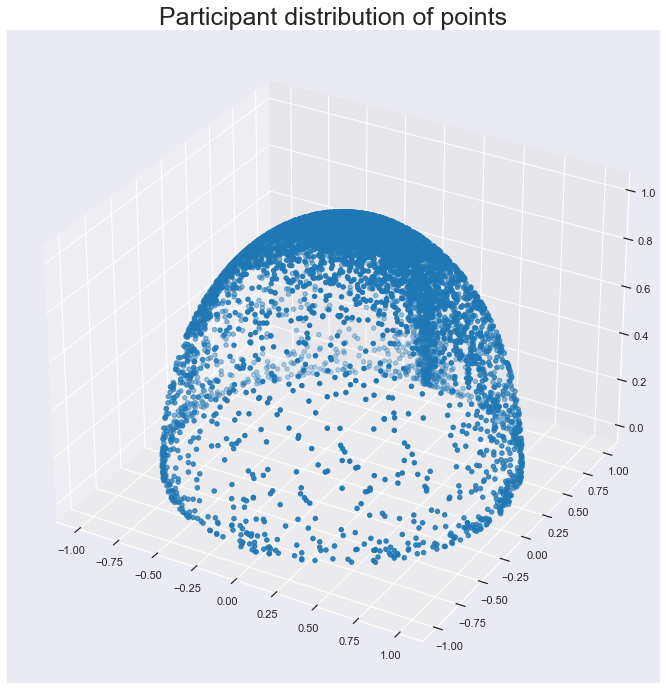

In [132]:
if experimentName != "nsd-surface-normals":

    fig = plt.figure(figsize=(16,12))
    ax1 = fig.add_subplot( 1, 2, 1, projection='3d')
    ax2 = fig.add_subplot( 1, 2, 2, projection='3d')

    ax1.set_title("True distribution of points", fontsize=25)
    ax2.set_title("Participant distribution of points", fontsize=25)
    ax1.scatter(true_directions[:, 0], true_directions[:, 1], true_directions[:, 2])
    ax2.scatter(indicator_directions[:, 0], indicator_directions[:, 1], indicator_directions[:, 2])

    angle = 45
    degrees = 30
    ax1.view_init(degrees, angle)
    ax2.view_init(degrees, angle)
else:
    fig = plt.figure(figsize=(16,12))
    ax1 = fig.add_subplot( 1, 1, 1, projection='3d')
    ax1.set_title("Participant distribution of points", fontsize=25)
    ax1.scatter(indicator_directions[:, 0], indicator_directions[:, 1], indicator_directions[:, 2])


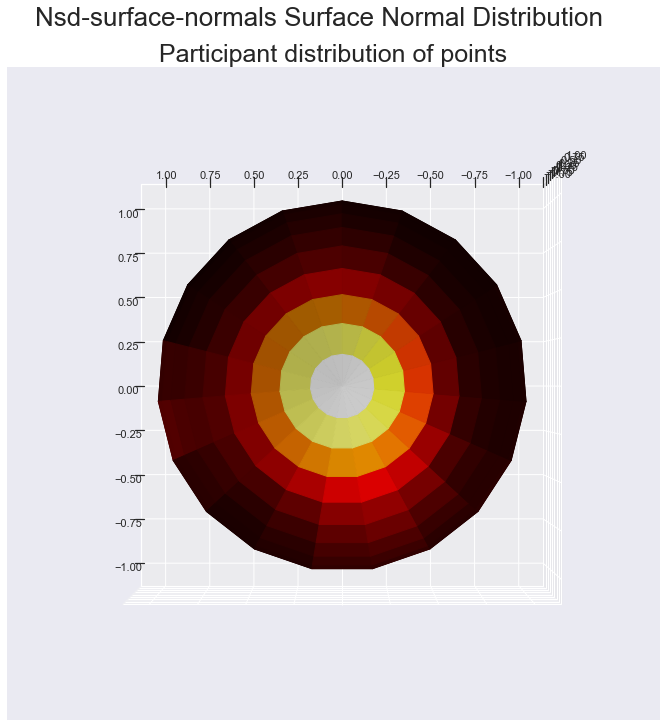

In [138]:
fig = plt.figure(figsize=(16,12))
if experimentName != "nsd-surface-normals":

    ax1 = fig.add_subplot( 1, 2, 1, projection='3d')
    ax2 = fig.add_subplot( 1, 2, 2, projection='3d')

    x, y, z = true_coords
    ax1.plot_surface(x, y, z, cstride=1, rstride=1, facecolors=cm.hot(gt_heatmap))

    x, y, z = participant_coords
    ax2.plot_surface(x, y, z, cstride=1, rstride=1, facecolors=cm.hot(participant_heatmap))

    ax1.set_title("True distribution of points", fontsize=25)
    ax2.set_title("Participant distribution of points", fontsize=25)

    angle = 180
    degrees = 90
    ax1.view_init(degrees, angle)
    ax2.view_init(degrees, angle)

    dataset = experimentName.split("_")[0]
    plt.suptitle(dataset.capitalize() + " Surface Normal Distribution", y=0.825)
    plt.show()
else: 
    ax1 = fig.add_subplot( 1, 1, 1, projection='3d')
    x, y, z = participant_coords
    ax1.plot_surface(x, y, z, cstride=1, rstride=1, facecolors=cm.hot(participant_heatmap))
    ax1.set_title("Participant distribution of points", fontsize=25)
    
    angle = 180
    degrees = 90
    ax1.view_init(degrees, angle)
    dataset = experimentName.split("_")[0]
    plt.suptitle(dataset.capitalize() + " Surface Normal Distribution", y=0.95)
    plt.show()

Text(0.5, 0.98, 'nsd-surface-normals')

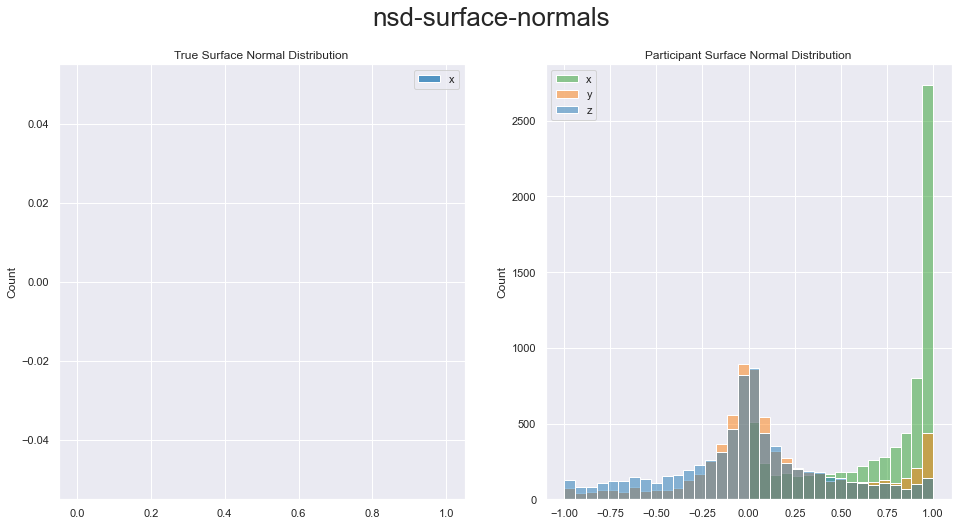

In [131]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
g = sns.histplot(true_directions, ax=axs[0])
axs[0].legend(["x","y","z"])
axs[0].set_title("True Surface Normal Distribution")

g = sns.histplot(indicator_directions, ax=axs[1])
axs[1].legend(["x","y","z"])
axs[1].set_title("Participant Surface Normal Distribution")
plt.suptitle(f"{experimentName}")

## Visualize the distribution of sampled points on images

In [55]:
plot_images = False

In [56]:
if plot_images:
    save_dir = os.path.join(f"figures/{experimentName}")
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    sns.set_style("white")
    for url, row in df.groupby("imageURL"):
        point_locs = row["arrowPixelPosition"]
        locs = set()
        for point in point_locs:
            locs.add(tuple(point))

        locs = list(locs)
        image = download_from_url(url)
        plt.close()
        fig,ax = plt.subplots(1, figsize=(12, 12))
        ax.set_aspect('equal')

        ax = draw_circles(ax, locs, size=15, lw=4)
        ax = draw_circles(ax, locs, size=10, lw=4)

        ax.imshow(image)
    #     pixelPositions = row["arrowPixelPosition"]
    #     idfs = row["indicatorFinalDirection"]
    #     for i in range(len(pixelPositions)):
    #         loc = pixelPositions.iloc[i]
    #         ifd = idfs.iloc[i]
    #         r = lambda: np.random.randint(0,255)
    #         color = '#%02X%02X%02X' % (r(),r(),r())
    #         ax.quiver(loc[1], loc[0], ifd[0], ifd[2], scale=ifd[1], color=color, angles="xy", scale_units='y')

        save_title = url.split("/")[-1]
        plt.savefig(os.path.join(save_dir, save_title))
        plt.show()


    sns.set_style("darkgrid")   